# Basic Raster Styling and Analysis

## Introduction

[`rioxarray`](https://corteva.github.io/rioxarray/stable/) and [`xarray-spatial`](https://xarray-spatial.readthedocs.io/en/stable/) extensions provide core functionality for working with geospatial rasters using XArray. In this tutorial, we will use these to read, analyze and reclassify population rasters.

## Overview of the Task

We will use the [Gridded Population of the World (GPW) v4](https://sedac.ciesin.columbia.edu/data/collection/gpw-v4) dataset from Columbia University. Specifically, the [Population Count](https://sedac.ciesin.columbia.edu/data/set/gpw-v4-population-count-rev11/data-download) for the entire globe at 2.5 Minute (~5Km) resolution in GeoTiFF format and for the year 2010 and 2020. Using these we will create a thematic map of the global population change between year 2010 and 2020.

**Input Layers**:
*   `gpw-v4-population-count-rev11_YYYY_2pt5_min_tif.zip`: Zipped Raster files having population data.

**Output**:
*   `change_class.tif` : A GeoTIFF file of categorized population change.

**Data Credit**:
*   Center for International Earth Science Information Network - CIESIN - Columbia University. 2018. Gridded Population of the World, Version 4 (GPWv4): Population Count, Revision 11. Palisades, NY: NASA Socioeconomic Data and Applications Center (SEDAC). https://doi.org/10.7927/H4JW8BX5. Accessed 27 JUNE 2019


## Setup and Data Download
The following blocks of code will install the required packages and download the datasets to your Colab environment.


In [1]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install rioxarray xarray-spatial

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import rioxarray as rxr
import xrspatial
import zipfile

In [3]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [4]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

data_url = 'https://github.com/spatialthoughts/geopython-tutorials/releases/download/data/'

gpw_pop_2010 = 'gpw-v4-population-count-rev11_2010_2pt5_min_tif.zip'
gpw_pop_2020 = 'gpw-v4-population-count-rev11_2020_2pt5_min_tif.zip'

download(data_url + gpw_pop_2010)
download(data_url + gpw_pop_2020)

Downloaded data/gpw-v4-population-count-rev11_2010_2pt5_min_tif.zip
Downloaded data/gpw-v4-population-count-rev11_2020_2pt5_min_tif.zip


## Procedure

Read the gridded population of the World files using the `rioxarray` by using [open_raster](https://docs.xarray.dev/en/stable/generated/xarray.open_rasterio.html) function. We can read the GeoTIFF file directly from the zip archive without uncompressing it first by creating a URI with the `zip://` prefix.

In [5]:
gpw_pop_2010_path = os.path.join(data_folder, gpw_pop_2010)

with zipfile.ZipFile(gpw_pop_2010_path) as f:
  files = f.namelist()
  for file in files:
    if os.path.splitext(file)[1] == '.tif':
      tif_file = file

gpw_pop_2010_uri = 'zip://{}!{}'.format(gpw_pop_2010_path, tif_file)
pop2010 = rxr.open_rasterio(gpw_pop_2010_uri, mask_and_scale=True)

In [6]:
gpw_pop_2020_path = os.path.join(data_folder, gpw_pop_2020)

with zipfile.ZipFile(gpw_pop_2020_path) as f:
  files = f.namelist()
  for file in files:
    if os.path.splitext(file)[1] == '.tif':
      tif_file = file

gpw_pop_2020_uri = 'zip://{}!{}'.format(gpw_pop_2020_path, tif_file)
pop2020 = rxr.open_rasterio(gpw_pop_2020_uri, mask_and_scale=True)

Now we will take the difference of the population

In [7]:
change = pop2020 - pop2010

`change` is a 3D array containing 1-band with pixel values with the population count different between the 2 years. We select the `band1` and visualize it using XArray's [`imshow()`](https://docs.xarray.dev/en/stable/generated/xarray.plot.imshow.html) method.

The values range from negative (reduction in population) to positive (increate in population). Since we are plotting diverging values, we can use a **Spectral** color ramp. We can anchor the visualization to a min/max range using `vmin` and `vmax` values. It is important to specify a `center` value so that the color ramp is centered at the specified value.

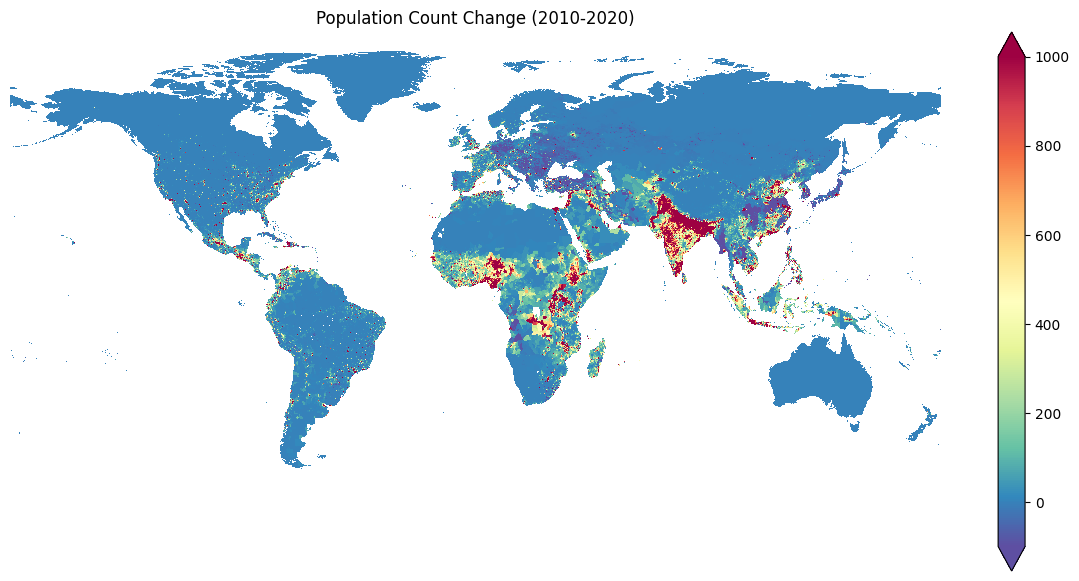

In [8]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15,7)

change.sel(band=1).plot.imshow(
    ax=ax, vmin=-100, vmax=1000, center=0,
    add_colorbar=True, cmap='Spectral_r')
ax.set_title('Population Count Change (2010-2020)')
ax.set_axis_off()

plt.show()

This is a good visualization, but not easy to interpret. Let’s create a better map with 4 discrete categories:

* **Negative**: Negative Cange upto -100.
* **Neutral**: Insignificant Negative or Positive Change between -100 to +100
* **Growth**: Small Positive Change between 100 to 1000.
* **High Growth**: Large Positive Change greater than 1000.

We use XArray Spatial's [`reclassify()`](https://xarray-spatial.org/reference/_autosummary/xrspatial.classify.reclassify.html) method to perform the reclassification from continuous values to 4 discrete classes.



In [12]:
class_bins = [-100, 100, 1000, np.inf]
class_values = [1, 2, 3, 4]
change_class = xrspatial.classify.reclassify(
    change.sel(band=1), bins=class_bins, new_values=class_values)

The result is a 2D array of reclassified values. We can visualize it the same way as before. The `imshow` method supports only a colorbar legend which is not appropriate for a discrete classified raster such as ours. We use Matplotlib's [`Patch()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch.html) method to create a patch with appropriate labels and colors as described in Matplotlib's [Legend guide](https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html).

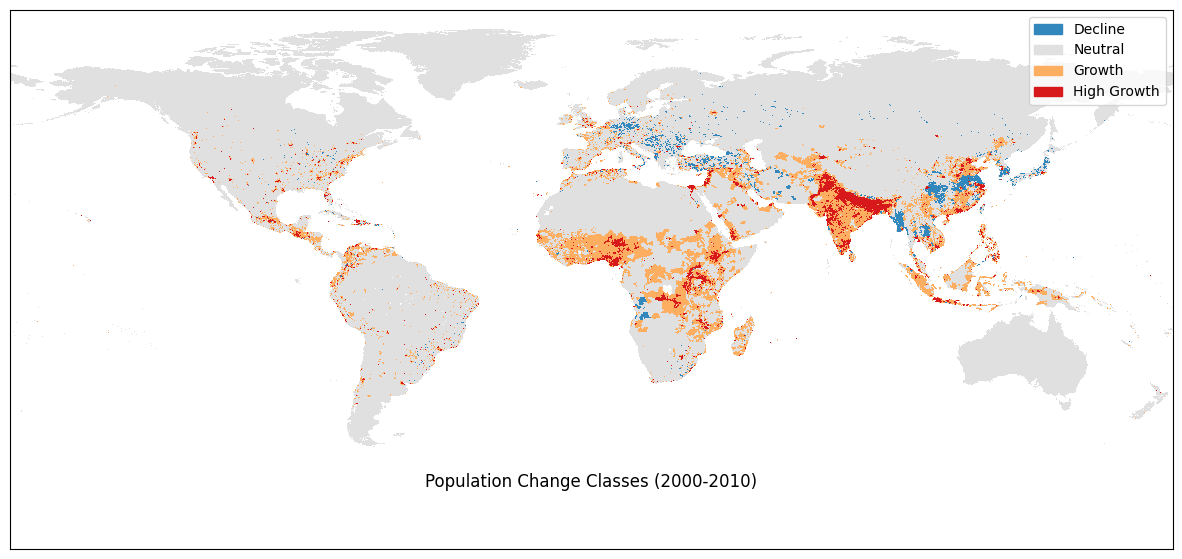

In [13]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15,7)

levels = class_values
colors = ['#3288bd', '#e0e0e0', '#fdae61', '#d7191c']
labels = ['Decline', 'Neutral', 'Growth', 'High Growth']

change_class.plot.imshow(
    ax=ax,
    add_colorbar=False,
    levels=[1, 2, 3, 4, 5],
    colors=colors)


patches =[mpatches.Patch(color=colors[i], label=labels[i]) for i in range(4)]
ax.legend(handles=patches)
ax.set_title('Population Change Classes (2010-2020)', y=0.1)

# Set axis labels off
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

Last step is to save the results to disk as a GeoTiff file.

In [14]:
output_file = 'change_class.tif'
output_file_path = os.path.join(output_folder, output_file)
change_class.rio.to_raster(output_file_path, compress='LZW')